# 4. Correlation Analysis

各細胞の発火時系列が与えられたとき，2細胞の発火の時間的相関（temporal correlation）から，ネットワークの構造を推定することができる．

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

plt.rcParams['font.size'] = 12
plt.rcParams['figure.dpi'] = 140

In [4]:
datadir = '../datasets/02/'
df = pd.read_csv(datadir + 'spikes_unit.csv', index_col=0)

display(df.head())

,unit,spiketime
0,0,-99618.990000
1,0,-96536.180002
2,0,-95920.130002
3,0,-93842.150003
4,0,-92885.660004


In [5]:
# filename = '../datasets/02/all.txt'
# spiketime = {}

# with open(filename) as f:
#     neuron_id = 0
#     spiketime[neuron_id] = []
    
#     for line in f:
#         value = line.rstrip()
        
#         if value == ';':
#             neuron_id += 1
#             spiketime[neuron_id] = []
#         else:
#             spiketime[neuron_id].append(value)
            
# lst_neurons = []
# lst_spiketime = []

# for key, value in spiketime.items():
#     lst_neurons.extend([key] * len(value))
#     lst_spiketime.extend(value)
    
# df = pd.DataFrame({'unit': lst_neurons, 'spiketime': lst_spiketime})
# df.to_csv('../datasets/02/spikes_unit.csv')

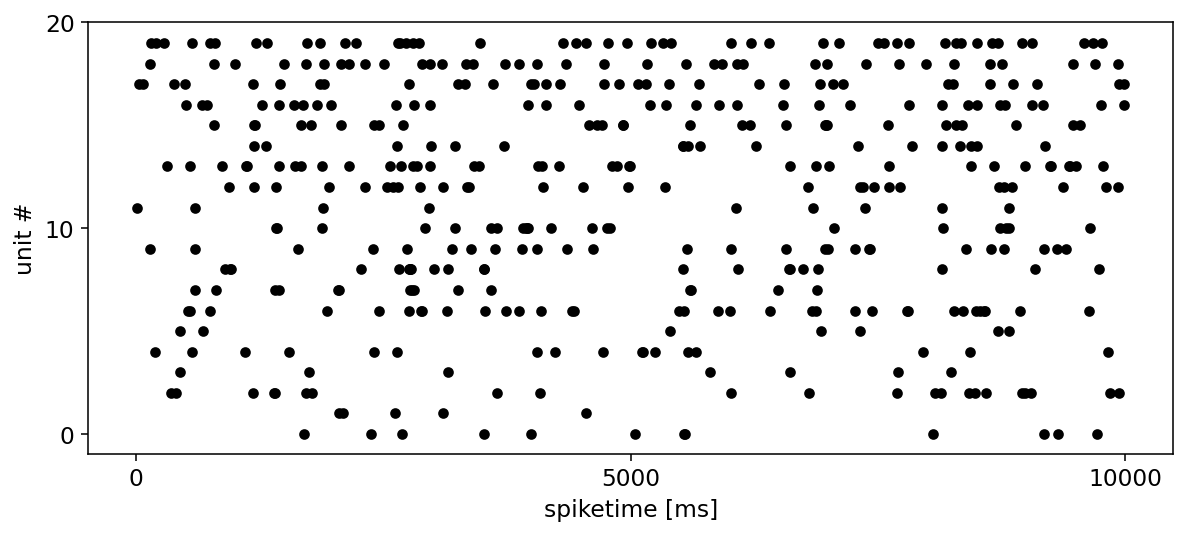

In [6]:
start, end = 0.0, 10000.0

fig, ax = plt.subplots(figsize=(10, 4))
df.query('@start <= spiketime <= @end').plot.scatter(x='spiketime', y='unit', c='k', ax=ax)
ax.set_xlabel('spiketime [ms]')
ax.set_ylabel('unit #')

ax.set_yticks([0, 10, 20])

plt.locator_params(axis='x', nbins=4)
plt.show()

## 4.1. Cross-Correlation

相互相関分析を行う際，発火時刻の列としてのspike train，またはbinningされたspike trainを扱う2種類の方法がある．binningとは，例えば0.5msのbinに時間を区切り，各binごとに何回のspikeが発生したかを行列（ベクトル）形式で格納する手法である．刺激後の神経活動（peri-stimulus time-histogram PSTH）を分析する際などはbinningされたspike trainを使うことが多いように思われる．

結合推定を行う際は，計測時間を長めに取ることが多いので，メモリ消費の少ないbinningされていないspike trainを扱うのが望ましいと考えられる．
この場合，相互相関ヒストグラムを取る手順は次のようになる．

1. 相互相関ヒストグラムの窓幅（50ms），bin幅（1ms）を決める．
2. 二つのspike train（reference unit: $j$, target unit: $i$）における各spikeについて，窓幅以内の時間差で発生した2つのspikeについて，相対発火時刻を列に格納する．相対発火時刻をreferenced spike trainと呼ぶこともある．
3. 相対発火時刻の列について，bin幅でヒストグラムを作成する．

```{tip}
相対発火時刻を計算する際，spike trainが昇順で並んでいることを前提に探索を行うのが効率的である．
```

In [7]:
def spiketime_relative(spike_times_i, spike_times_j, window_size=50.0):
    t_sp = []
    i_min, i_max = 0, 0

    for t_j in spike_times_j:
        # reuse search index for next iteration to decrease the amount of elements to scan
        i_min = _upper_bound_idx(lst=spike_times_i, upper=t_j - window_size, start_idx=i_min)
        i_max = _upper_bound_idx(lst=spike_times_i, upper=t_j + window_size, start_idx=i_max)
        t_sp.extend([(spike_times_i[i] - t_j) for i in range(i_min, i_max)])
        
    return t_sp

def _upper_bound_idx(lst, upper, start_idx=0):
    idx = start_idx
    while idx < len(lst) and lst[idx] <= upper:
        idx += 1
    return idx

def cross_correlogram(spike_times_i, spike_times_j, window=50., nbins=100):
    t_sp = spiketime_relative(spike_times_i, spike_times_j)
    hist, edges = np.histogram(t_sp, bins=np.linspace(-window, window, nbins))
    return hist, edges

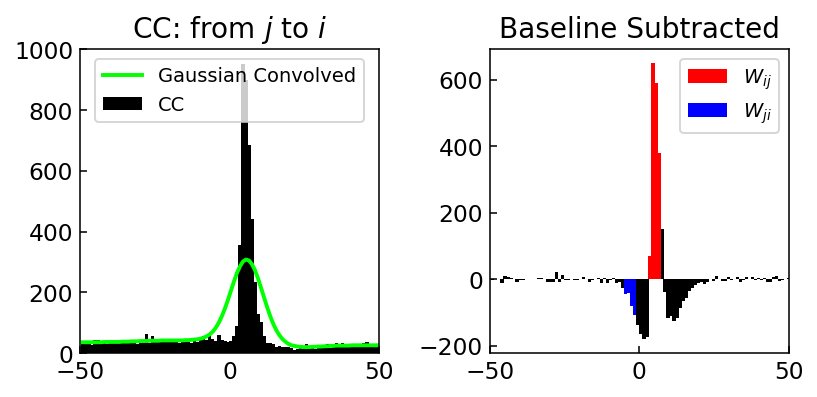

In [8]:
i, j = 18, 11
spike_times_i = df.query(f'unit=={i}').spiketime.values
spike_times_j = df.query(f'unit=={j}').spiketime.values

hist, edges = cross_correlogram(spike_times_i, spike_times_j)
hist_g = gaussian_filter(hist, sigma=[5])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3))

ax1.set_title(r'CC: from $j$ to $i$')
ax1.bar(edges[1:], hist, color='k', width=1.1, label='CC')
ax1.plot(edges[1:], hist_g, color='lime', linewidth=2.0, label='Gaussian Convolved')
ax1.legend(fontsize=10, loc='upper center')
ax1.set_xlim(-50, 50)
ax1.set_xticks([-50, 0, 50])
ax1.tick_params(direction='in')

hist_sub = hist - hist_g
ax2.set_title('Baseline Subtracted')
ax2.bar(edges[1:], hist_sub, color='k', width=1.1)

ax2.bar(edges[1:][52:56], hist_sub[52:56], color='r', width=1.1, label=r'$W_{ij}$')
ax2.bar(edges[1:][44:48], hist_sub[44:48], color='b', width=1.1, label=r'$W_{ji}$')
ax2.legend(fontsize=10, loc='upper right')
ax2.set_xlim(-50, 50)
ax2.set_xticks([-50, 0, 50])
ax2.tick_params(direction='in')

plt.tight_layout()
plt.show()

## 4.2. Effective Connectivity

```{note}
$W_{ij}$: neuron $j$からneuron $i$へのシナプス強度とする．
```

In [9]:
import itertools
import seaborn as sns
import networkx as nx

In [10]:
def estimate_connectivity(spike_times_i, spike_times_j, start=2, end=6, window=50., nbins=100):
    hist, edges = cross_correlogram(spike_times_i, spike_times_j, window, nbins)
    hist_g = gaussian_filter(hist, sigma=[5])
    hist_sub = hist - hist_g

    w_ij = np.sum(hist_sub[nbins // 2 + start : nbins // 2 + end]) / len(spike_times_j)
    w_ji = np.sum(hist_sub[nbins // 2 - end : nbins // 2 - start]) / len(spike_times_i)
    return w_ij, w_ji

In [11]:
neurons = set(df.unit)
n_neurons = len(neurons)
w = np.zeros((n_neurons, n_neurons))

for (i, j) in itertools.combinations(neurons, 2):
    if i == j:
        continue
    else:
        spike_times_i = df.query(f'unit=={i}').spiketime.values
        spike_times_j = df.query(f'unit=={j}').spiketime.values
        w_ij, w_ji = estimate_connectivity(spike_times_i, spike_times_j)
        w[i, j] = w_ij
        w[j, i] = w_ji

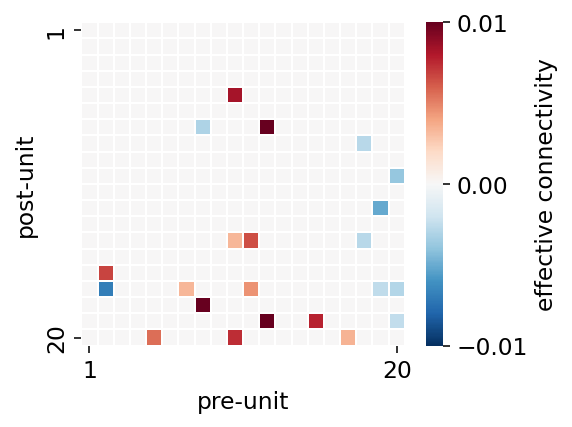

In [12]:
fig, ax = plt.subplots(figsize=(4, 3))

# thresholding weight matrix
w_ = np.zeros_like(w)

thre_exc = 0.003
thre_inh = 0.002
w_[w > thre_exc] = w[w > thre_exc]
w_[w < -thre_inh] = w[w < -thre_inh]

# plotting
sns.heatmap(w_, vmax=0.01, vmin=-0.01, center=0, ax=ax, cmap=plt.get_cmap('RdBu_r'), 
            linewidths=1.0, cbar_kws=dict(ticks=[0.01, 0, -0.01], label='effective connectivity'))

ax.set_xticks([0.5, 19.5])
ax.set_yticks([0.5, 19.5])
ax.set_xticklabels([1, 20])
ax.set_yticklabels([1, 20])

ax.set_xlabel('pre-unit')
ax.set_ylabel('post-unit')
ax.set_aspect('equal')
plt.show()

```{note}
推定されたシナプス強度は，同じpre-unit（シナプス前細胞）について，興奮性あるいは抑制性の分類が一貫しているか確かめると良い．上の例では，列方向（縦）．例えば，neuron 18, 19, 20は抑制性細胞である可能性が高い．
```

## 4.3. Visualizing Connectivity with Networkx

推定された実効的結合強度に基づき，神経ネットワークをnetworkxにより可視化するコードの一例を以下に示す．

In [13]:
G = nx.DiGraph()

for neuron in neurons:
    G.add_node(neuron + 1)

for i in range(w.shape[0]):
    for j in range(w.shape[1]):
        w_ij = w[i, j]
        if w_ij > thre_exc:
            G.add_edge(i + 1, j + 1, weight=w_ij, color='magenta')  # exc
        elif w_ij < -thre_inh:
            G.add_edge(i + 1, j + 1, weight=w_ij, color='cyan')  # inh

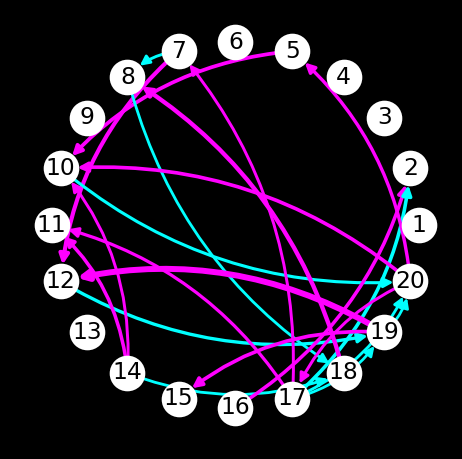

In [14]:
edges = G.edges()
edge_color = [G[u][v]['color'] for u, v in edges]
edge_width = [np.log10(abs(G[u][v]['weight'])) + 4 for u, v in edges]

fig, ax = plt.subplots(figsize=(4, 4))
nx.draw(G, pos=nx.circular_layout(G), with_labels=True, node_color='w', font_color='k', 
        edge_color=edge_color, width=edge_width, arrows=True, arrowsize=10, connectionstyle='arc3, rad=0.2')

fig.set_facecolor('k')
plt.show()

また，ネットワークはBokehを使えばインタラクティブに可視化することもできる．ただしBokehでは有向グラフを矢印付きで可視化する機能がない．

In [15]:
from bokeh.io import show, output_notebook
from bokeh.plotting import curdoc, figure, from_networkx
from bokeh.models import Circle, MultiLine, NodesAndLinkedEdges
from bokeh.palettes import Spectral8
output_notebook()

Loading BokehJS ...

In [18]:
def make_network_plot(G, pos):
    node_highlight_color = Spectral8[4]
    edge_highlight_color = Spectral8[4]
    
    HOVER_TOOLTIPS = [("neuron", "@index"), ("degree", "@degree")]
    plot = figure(tooltips = HOVER_TOOLTIPS, tools="pan,box_zoom,wheel_zoom,save,reset", width=400, height=400)
    
    plot.axis.major_tick_line_color = None
    plot.axis.minor_tick_line_color = None
    plot.axis.major_label_text_color = None  
    plot.xgrid.visible = False
    plot.ygrid.visible = False  
    
    network_graph = from_networkx(G, pos, scale=8, center=(0, 0))
    network_graph.node_renderer.glyph = Circle(size=20, fill_color='white', fill_alpha=0.7)
    network_graph.node_renderer.hover_glyph = Circle(size=20, fill_color=node_highlight_color, line_width=2)
    network_graph.node_renderer.selection_glyph = Circle(size=20, fill_color=node_highlight_color, line_width=2)

    network_graph.edge_renderer.glyph = MultiLine(line_color='edge_color', line_alpha=0.8, line_width='edge_width')
    network_graph.edge_renderer.selection_glyph = MultiLine(line_color=edge_highlight_color, line_width='edge_width')
    network_graph.edge_renderer.hover_glyph = MultiLine(line_color=edge_highlight_color, line_width='edge_width')
    
    network_graph.selection_policy = NodesAndLinkedEdges()
    network_graph.inspection_policy = NodesAndLinkedEdges()
    plot.renderers.append(network_graph)
    return plot

In [19]:
# node attributes
nx.set_node_attributes(G, name='degree', values=dict(nx.degree(G)))

# edge attributes
edges = G.edges()
edge_color = {(u, v): G[u][v]['color'] for u, v in edges}
edge_width = {(u, v): np.log10(abs(G[u][v]['weight'])) + 8 for u, v in edges}

nx.set_edge_attributes(G, edge_color, "edge_color")
nx.set_edge_attributes(G, edge_width, "edge_width")

curdoc().theme = 'dark_minimal'
p = make_network_plot(G, nx.circular_layout(G))
show(p)